In [32]:

from sionna.rt import load_scene, RadioMapSolver, Transmitter, PlanarArray, Scene, \
                      DEFAULT_FREQUENCY, DEFAULT_BANDWIDTH, DEFAULT_TEMPERATURE
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import c

from tqdm import tqdm

In [33]:
lambda_ = c / DEFAULT_FREQUENCY
step_size = lambda_ / 20
positions = np.arange(1, 10, step_size)

dx = dy = lambda_ / 10.0
GRID_N = 512
SIZE_X = GRID_N * dx
SIZE_Y = GRID_N * dy

In [34]:
def path_gain_loss_test(scene, positions: np.ndarray) -> np.ndarray:
    scene.tx_array = PlanarArray(num_rows=1, num_cols=1, polarization='V', pattern='iso')
    scene.remove('tx1'); scene.remove('tx2')
    tx1 = Transmitter('tx1', position=[0.0, 0.0, 10.0])
    scene.add(tx1)

    results = np.zeros((len(positions), GRID_N, GRID_N), dtype=float)

    for i, pos in tqdm(enumerate(positions), total=len(positions)):
        scene.remove('tx2')
        tx2 = Transmitter('tx2', position=[-float(pos), 0.0, 10.0])
        scene.add(tx2)

        rm_solver = RadioMapSolver()
        rm = rm_solver(
            scene,
            max_depth=5,
            samples_per_tx=10**6,
            cell_size=(dx, dy),               # lambda_/10
            center=(0.0, 0.0, 0.0),
            size=(SIZE_X, SIZE_Y),            # Nx*dx, Ny*dy
            orientation=(0.0, 0.0, 0.0)
        )

        results[i] = np.max(rm.path_gain, axis=0)

    return results

def heatmap(z: np.ndarray) -> None:
    """Plot the path gain map using matplotlib."""
    plt.imshow(z, cmap='viridis', origin='lower')
    plt.colorbar(label='Path Gain (dB)')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Path Gain Map')
    plt.show()

In [35]:
res = path_gain_loss_test(load_scene(), positions)

100%|██████████| 2102/2102 [03:47<00:00,  9.24it/s]


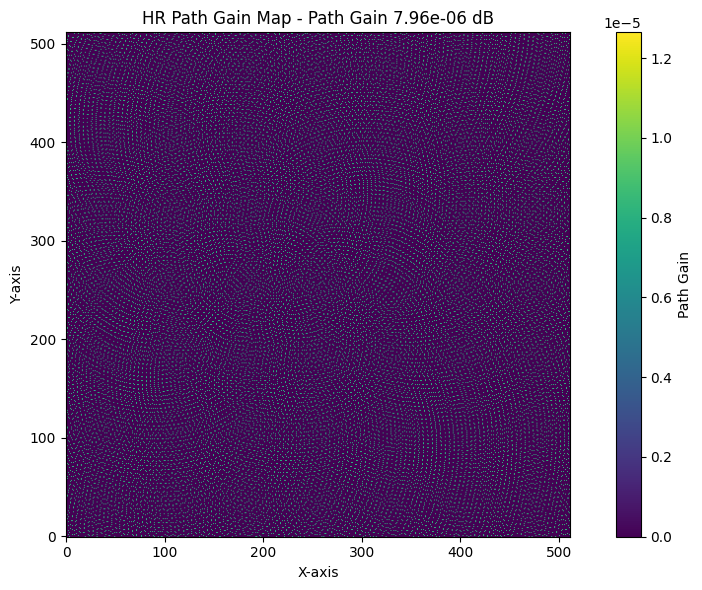

KeyboardInterrupt: 

In [37]:
plt.ion()
fig, ax = plt.subplots(1, figsize=(12, 6))

# Fix color limits across frames
rmin, rmax = np.nanmin(res), np.nanmax(res)

# Initialize the first frame
im0 = ax.imshow(res[0], cmap='viridis', origin='lower',
                   vmin=rmin, vmax=rmax)
# include tx positions as scatter points
tx1_pos = np.array([0.0, 0.0, 10.0])
tx2_pos = np.array([-float(positions[0]), 0.0, 10.0])
ax.scatter(tx1_pos[0], tx1_pos[1], color='red', label='TX1', s=100)
ax.scatter(tx2_pos[0], tx2_pos[1], color='blue', label='TX2', s=100)
ax.legend()

ax.set_title(f'HR Path Gain Map - Position {positions[0]}')
ax.set_xlabel('X-axis'); ax.set_ylabel('Y-axis')
cbar0 = fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)
cbar0.set_label('Path Gain')

fig.tight_layout()

for i in range(len(positions)):
    im0.set_data(res[i])

    # Compute approximate path gain in the center
    hr_pg = res[i][res[i].shape[0] // 2, res[i].shape[1] // 2]

    ax.set_title(f'HR Path Gain Map - Path Gain {hr_pg:.2e} dB')

    plt.pause(0.3)

plt.ioff()
plt.show()